In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')

In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy

In [4]:
from patient.utils import get_results_matching_parameters,aggregate_data, aggregate_normalize_data

In [5]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [6]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [7]:
colors_by_method = {}
baseline_methods = ['random','greedy','whittle_activity']
offline_methods = ['offline_solution','offline_learning_solution','offline_solution_balance']
online_methods = ['p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(offline_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(online_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(offline_methods):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(online_methods):
    colors_by_method[m] = wistia[i]
colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

## Performance Comparison

/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]


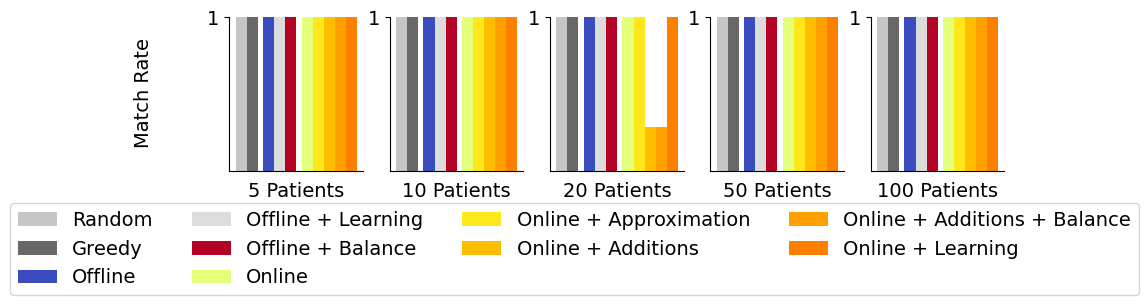

In [11]:
fig, axs = plt.subplots(1,5, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
n_patients = [5,10,20,50,100]

baseline_params = {'provider_capacity': 1,'top_choice_prob': 0.75,'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 1}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_patients):
    baseline_params['num_patients'] = n
    baseline_params['num_providers'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")
            if '{}_matches'.format(m) not in results:
                    results['{}_matches'.format(m)] = [0,0]
            score_by_n.append(results['{}_matches'.format(m)][0])
            std_by_n.append(results['{}_matches'.format(m)][1]/(num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0.9,1])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Patients".format(n_patients[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_patients.pdf",dpi=300, bbox_inches='tight')


/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]


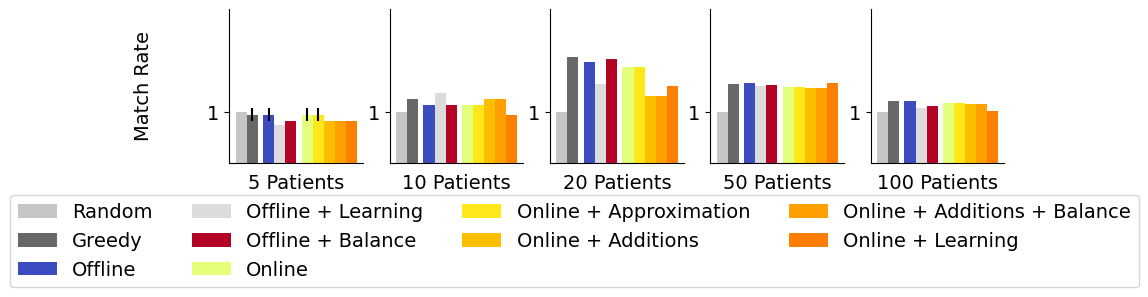

In [9]:
fig, axs = plt.subplots(1,5, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
n_patients = [5,10,20,50,100]

baseline_params = {'provider_capacity': 1,'top_choice_prob': 0.75,'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 1}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_patients):
    baseline_params['num_patients'] = n
    baseline_params['num_providers'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")
            if '{}_utilities'.format(m) not in results:
                    results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0.9,1.2])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Patients".format(n_patients[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_providers.pdf",dpi=300, bbox_inches='tight')


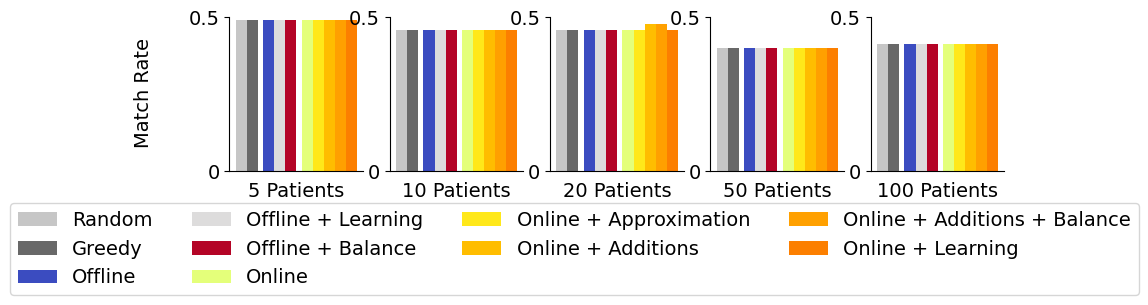

In [10]:
fig, axs = plt.subplots(1,5, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
n_patients = [5,10,20,50,100]

baseline_params = {'provider_capacity': 1,'top_choice_prob': 0.75,'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 1}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_patients):
    baseline_params['num_patients'] = n
    baseline_params['num_providers'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)

        for lst in results:
            for key in lst:
                if 'workload' in key:
                    lst[key] = [float(np.std(j)) for j in lst[key]]
                    
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_data(results)
            if '{}_workloads'.format(m) not in results:
                    results['{}_workloads'.format(m)] = [0,0]
            score_by_n.append(results['{}_workloads'.format(m)][0])
            std_by_n.append(results['{}_workloads'.format(m)][1]/(num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0,0.5])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Patients".format(n_patients[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_providers.pdf",dpi=300, bbox_inches='tight')


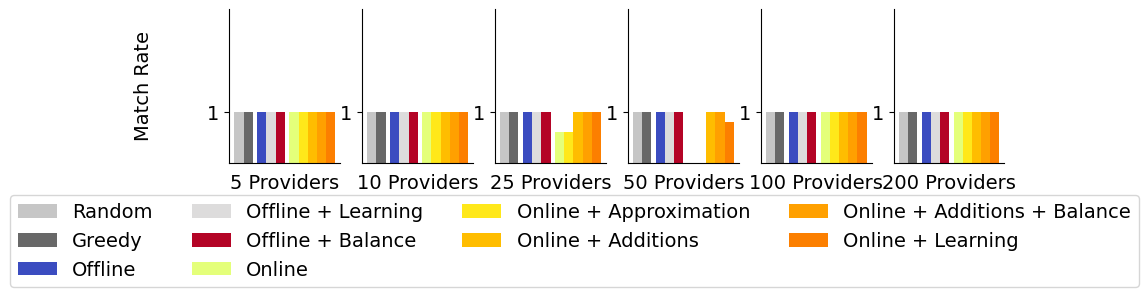

In [13]:
fig, axs = plt.subplots(1,6, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
n_providers = [5,10,25,50,100,200]

baseline_params = {'provider_capacity': 1,'top_choice_prob': 0.75,'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 1, 'num_patients': 100}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_providers):
    baseline_params['num_providers'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")
            if '{}_matches'.format(m) not in results:
                    results['{}_matches'.format(m)] = [0,0]
            score_by_n.append(results['{}_matches'.format(m)][0])
            std_by_n.append(results['{}_matches'.format(m)][1]/(num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0.9,1.2])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Providers".format(n_providers[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_patients.pdf",dpi=300, bbox_inches='tight')


/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]


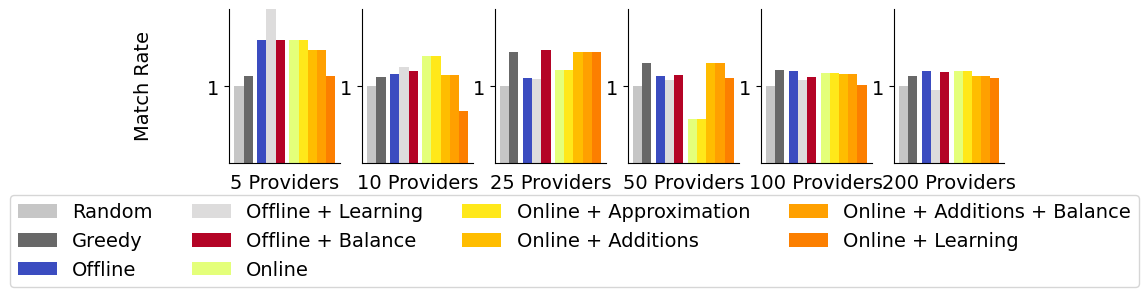

In [20]:
fig, axs = plt.subplots(1,6, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
n_providers = [5,10,25,50,100,200]

baseline_params = {'provider_capacity': 1,'top_choice_prob': 0.75,'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 1, 'num_patients': 100}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_providers):
    baseline_params['num_providers'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")
            if '{}_utilities'.format(m) not in results:
                    results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0.9,1.1])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Providers".format(n_providers[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_patients.pdf",dpi=300, bbox_inches='tight')


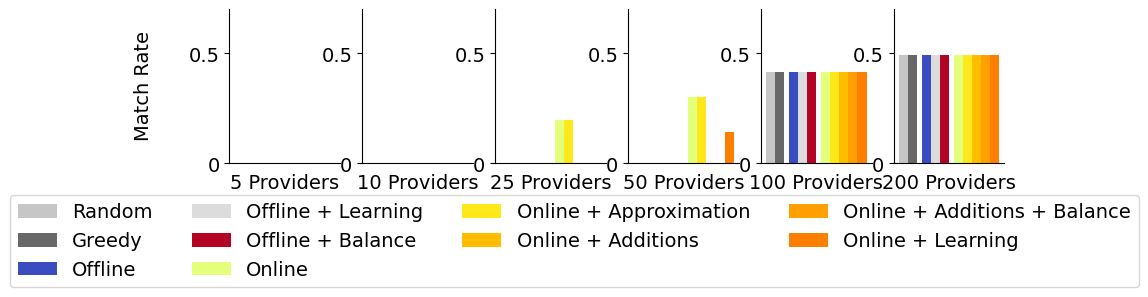

In [13]:
fig, axs = plt.subplots(1,6, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
n_providers = [5,10,25,50,100,200]

baseline_params = {'provider_capacity': 1,'top_choice_prob': 0.75,'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 1, 'num_patients': 100}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_providers):
    baseline_params['num_providers'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"

        
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        
        for lst in results:
            for key in lst:
                if 'workload' in key:
                    lst[key] = [float(np.std(j)) for j in lst[key]]
        
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_data(results)
            if '{}_workloads'.format(m) not in results:
                    results['{}_workloads'.format(m)] = [0,0]
            score_by_n.append(results['{}_workloads'.format(m)][0])
            std_by_n.append(results['{}_workloads'.format(m)][1]/(num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0,0.7])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Providers".format(n_providers[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_patients.pdf",dpi=300, bbox_inches='tight')


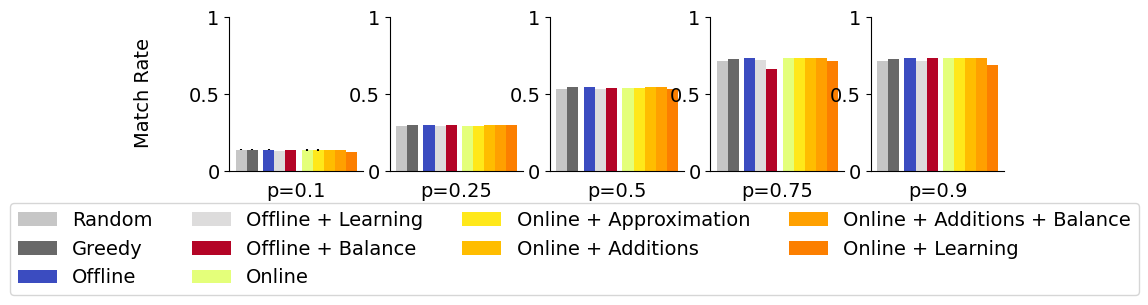

In [14]:
fig, axs = plt.subplots(1,5, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
choice_prob = [0.1,0.25,0.5,0.75,0.9]

baseline_params = {'provider_capacity': 1,'num_providers': 25, 'num_patients': 25,'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 1}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(choice_prob):
    for k,m in enumerate(method_names):
        baseline_params['top_choice_prob'] = n
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_data(results)
            if '{}_utilities'.format(m) not in results:
                    results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0]/(25))
            std_by_n.append(results['{}_utilities'.format(m)][1]/(25*num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0,1])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)



for i in range(len(axs)):
    axs[i].set_xlabel("p={}".format(choice_prob[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_patients.pdf",dpi=300, bbox_inches='tight')


/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:156: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = data_point[key]/avg_by_type[data_type]
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


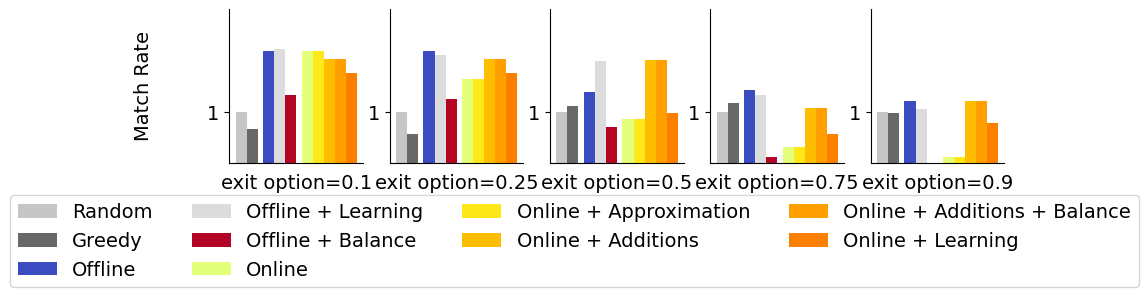

In [19]:
fig, axs = plt.subplots(1,5, figsize=(10, 2))
method_names = ['random','greedy','offline_solution','offline_learning_solution','offline_solution_balance','p_approximation','p_approximation_balance','p_approximation_additions','p_approximation_additions_balance','p_approximation_additions_balance_learning']
nice_names = ["Random","Greedy","Offline","Offline + Learning","Offline + Balance","Online","Online + Approximation","Online + Additions","Online + Additions + Balance","Online + Learning"]
width = 0.1
exit_options = [0.1,0.25,0.5,0.75,0.9]

baseline_params = {'provider_capacity': 1,'num_providers': 25, 'top_choice_prob': 0.75,'num_patients': 25,'choice_model': 'mnl','exit_option': 0.5,'num_trials': 1}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    elif method_names[i] == 'p_approximation':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(exit_options):
    for k,m in enumerate(method_names):
        baseline_params['exit_option'] = n
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline='random')
            if '{}_utilities'.format(m) not in results:
                    results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0.9,1.2])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)



for i in range(len(axs)):
    axs[i].set_xlabel("exit option={}".format(exit_options[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Rate",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_patients.pdf",dpi=300, bbox_inches='tight')
